# Identity Fraud from Enron Email and Financial Data 
Joshua Tice
## Introduction  
The goal of this project was to use a supervised machine learning algorithm to identify Enron employees who committed fraud based on the public Enron Email and Financial Dataset. Machine learning was a particularly useful tool in identifying persons of interest because its algorithms could identify patterns and relationships in high-dimensional data that were difficult for a human mind to discern.  
## Exploratory data analysis
Before discussing the exploratory analysis of the dataset, I loaded a series of libraries and modules that were used throughout the project.

In [331]:
#!/usr/bin/python

# General imports
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint
import seaborn as sns
import sys

# Udacity module imports
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
import tester
from tester import dump_classifier_and_data
from tester import test_classifier

# Scikit-Learn imports
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import chi2, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Imbalanced-Learn imports
from imblearn.over_sampling import ADASYN



The curated dataset was provided by Udacity as a pickle file, which was subsequently loaded into a Python dictionary with the following code.

In [332]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

I ported the dictionary into a Pandas dataframe so that I could perform a preliminary exploratory data analysis. I started by viewing the features that were available as well as a sample of the datapoints.

In [333]:
# Import data into dataframe for EDA
df = pd.DataFrame.from_records(list(data_dict.values()))
employees = pd.Series(list(data_dict.keys()))
df.set_index(employees, inplace=True)

# Basic EDA
# Inspect features
print(df.info())
# Sample data at the head of the dataset
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
bonus                        146 non-null object
deferral_payments            146 non-null object
deferred_income              146 non-null object
director_fees                146 non-null object
email_address                146 non-null object
exercised_stock_options      146 non-null object
expenses                     146 non-null object
from_messages                146 non-null object
from_poi_to_this_person      146 non-null object
from_this_person_to_poi      146 non-null object
loan_advances                146 non-null object
long_term_incentive          146 non-null object
other                        146 non-null object
poi                          146 non-null bool
restricted_stock             146 non-null object
restricted_stock_deferred    146 non-null object
salary                       146 non-null object
shared_receipt_with_poi      146 non-null object

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


I saw that most of the features contained mixed datatypes due to the presence of 'NaN' strings included for missing values. I subsequently replaced these values with the numpy respresentation for null values and re-printed the info for the dataset.

In [334]:
# Replace 'NaN' strings with Numpy nan representation
df.replace('NaN', np.nan, inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                111 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
poi                          146 non-null bool
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_receipt_with_poi      86 non-null float6

The data had a mixture of financial features, features related to emails, and a classification. The 14 financial features were reported in units of US dollars:  
* bonus
* deferral payments
* deferred income
* director fees
* exercised stock options
* expenses
* loan advances
* long term incentive
* other
* restricted stock
* restricted stock deferred
* salary
* total payments
* total stock value  

The 6 features related to emails were reported in units of counts (except email address, which was a string): 

* email address
* from messages
* from poi to this person
* from this person to poi
* shared receipt with poi
* to messages  

The classification feature (poi) was a boolean.

I was interested in the allocation between the two different classes (poi and non-poi), because the efficacy of the learning algorithm could have been affected negatively by inbalanced classes.

In [335]:
# What is the allocation across classes (non-POI and POI)?
count_poi = sum(df.poi)
count_non_poi = sum(np.array(df.poi) == False)
fraction_poi = count_poi / (count_poi + count_non_poi)
print("Data points labelled 'POI': {}".format(count_poi))
print("Data points labelled 'non-POI': {}".format(count_non_poi))
print("Fraction of data points labelled 'POI': {:.2}".format(fraction_poi))

Data points labelled 'POI': 18
Data points labelled 'non-POI': 128
Fraction of data points labelled 'POI': 0.12


Seeing that the poi class composed only 12% of the data, I decided to investigate an up-sampling strategy later to equally populate both classes.  

Many of the features had a significant fraction of missing values. I re-sorted the features based on the number of 'nan's and also plotted a histogram to visualize the distribution of missing values in the dataset.

Feature | Number of missing values
[('loan_advances', 142),
 ('director_fees', 129),
 ('restricted_stock_deferred', 128),
 ('deferral_payments', 107),
 ('deferred_income', 97),
 ('long_term_incentive', 80),
 ('bonus', 64),
 ('to_messages', 60),
 ('from_poi_to_this_person', 60),
 ('from_messages', 60),
 ('from_this_person_to_poi', 60),
 ('shared_receipt_with_poi', 60),
 ('other', 53),
 ('salary', 51),
 ('expenses', 51),
 ('exercised_stock_options', 44),
 ('restricted_stock', 36),
 ('email_address', 35),
 ('total_payments', 21),
 ('total_stock_value', 20),
 ('poi', 0)]


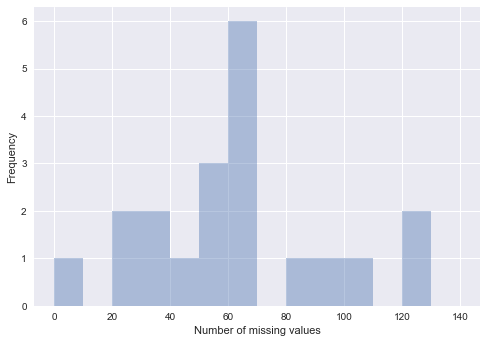

In [336]:
# Investigate missing values
missing_value_dict = {}
for col in df.columns:
    missing_value_dict[col] = sum(df[col].isnull())
print("Feature | Number of missing values")
pprint.pprint(sorted(missing_value_dict.items(), key=lambda x: x[1], reverse=True))

sns.distplot(missing_value_dict.values(), bins=range(0, 150, 10), kde=False)
plt.xlabel('Number of missing values')
plt.ylabel('Frequency')
plt.show()

## Initial feature selection

In some data analyses, a prevalance of missing values might have been a legitimate reason to remove a feature before implementing a learning algorithm. However, in this analysis, I knew that many persons of interest held positions at the top of the organization. Hence, features that might not have been relevant for an average employee (*e.g.*, director fees) might have been highly relevant to employees in upper management and consequently highly useful for the machine learning algorithm. Consequently, I did not remove any features based on missing values. In the above exploratory analysis, I represented missing values as 'nan's. However, when applying the learning algorithm, it made logical sense to represent the missing values as 0 USD or 0 counts. Code below provided by Udacity made this transformation during the data import process for machine learning.

I did remove one feature at this stage - email address. I believed that the the email address of each individual was unlikely to contain any information relevant for machine learning. This feature was essentially a unique string identifier for each data point, and basically a redundant index, but with missing values for some data points. 

In [337]:
# Task 1: Select what features you'll use.
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".

feature_list = [
    'poi',  
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    #'email_address',
    'exercised_stock_options',
    'expenses',
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'shared_receipt_with_poi',
    'to_messages',
    'total_payments',
    'total_stock_value'
]  

## Outlier removal

Based on the "Outliers" lesson from Udacity's "Intro to Machine Learning" course, I knew that the data contained one outlier that needed to be removed - a data point corresponding to the cumulative total for each features. I did not remove any other outliers from the data because in this particular machine learning exercise, I was purposefully trying to identify individuals that could be seen as anomalies. In all likelihood, many of the outliers probably provided the most useful information for the algorithm.

In [338]:
# Task 2: Remove outliers
del(data_dict['TOTAL'])

## Creation of new features

I created two new features from the supplied data. The first, 'ratio_poi_from_messages', was the number of emails sent from persons of interest to an individual normalized by the total number of emails the individual received. I reasoned that if a person received a high volume of emails in general (*e.g.*, an administrative assistant), then that person might also have a high count of emails from poi's by coincidence. The fraction of emails from poi might be a better indicator of affiliation with a poi. Likewise, I normalized the number of emails each individual sent to poi's by the total number of emails sent ('ratio_poi_to_messages').

In [339]:
# Task 3: Create new feature(s)
for key in data_dict.keys():
    if (data_dict[key]['from_poi_to_this_person'] == 'NaN') or \
       (data_dict[key]['from_messages'] == 'NaN'):
        data_dict[key]['ratio_poi_from_messages'] = 'NaN'
    else:
        data_dict[key]['ratio_poi_from_messages'] = \
        data_dict[key]['from_poi_to_this_person'] / \
        data_dict[key]['from_messages']
    if (data_dict[key]['from_this_person_to_poi'] == 'NaN') or \
       (data_dict[key]['to_messages'] == 'NaN'):
        data_dict[key]['ratio_poi_to_messages'] = 'NaN'
    else:
        data_dict[key]['ratio_poi_to_messages'] = \
        data_dict[key]['from_this_person_to_poi'] / \
        data_dict[key]['to_messages']
feature_list.append('ratio_poi_from_messages')
feature_list.append('ratio_poi_to_messages')

## Feature scaling

Some of the features in the dataset had drastically different ranges. For instance, the features that I created above were purposefully created on a scale of 0 to 1, while some of the provided financial features had values in the millions of dollars. While not all learning algorithms require feature scaling, some could have substantially biased by non-normalized data, such as SVM's or linear models. To make sure all the features had similar ranges, I applied a simple min/max scaler to the data. At this point, the data were transferred to a Numpy array to be compatible with SciKit-Learn's code.

In [340]:
# Extract features and labels from dataset for local testing
dataset = featureFormat(data_dict, feature_list, sort_keys=True)
labels, features = targetFeatureSplit(dataset)

# Scale features 
#scaler = MinMaxScaler()
#features = scaler.fit_transform(features)

In [270]:
# TESTING TESTING (GRADIENT BOOST TUNE)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

# Define classifier
boost = GradientBoostingClassifier( 
    loss='deviance', 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample=1.0, 
    criterion='friedman_mse', 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_depth=3, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    init=None, 
    random_state=42, 
    max_features=None, 
    verbose=0, 
    max_leaf_nodes=None, 
    warm_start=False, 
    presort='auto'
)

# Tune classifier with grid search 
# Ref: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
param_grid = [
    {
        #'n_estimators': [],
        'learning_rate': [0.001, 0.01, 0.1],
    }
]
clf = GridSearchCV(boost, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='recall')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
print("Best f1 score {:.2}".format(clf.best_score_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("Precision / Recall")
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

Best parameters {'learning_rate': 0.1}
Best f1 score 0.21
Precision: 0.350574462574
Recall: 0.21
Precision / Recall
[(0.0, 0.0),
 (0.25143265993265995, 0.10222222222222223),
 (0.35057446257446256, 0.20999999999999999)]


In [274]:
clf_test = clf.best_estimator_
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
	Accuracy: 0.85260	Precision: 0.39962	Recall: 0.21000	F1: 0.27532	F2: 0.23202
	Total predictions: 15000	True positives:  420	False positives:  631	False negatives: 1580	True negatives: 12369



In [290]:
# TESTING TESTING (ADABOOST TUNE)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

# Define classifier
boost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(
        criterion='gini', 
        splitter='best',
        max_depth=None, # Tune this guy
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features= 'sqrt',
        random_state=42,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_impurity_split=None,
        class_weight='balanced',
        presort=False
    ), 
    n_estimators=50, 
    learning_rate=1.0, 
    algorithm='SAMME.R', 
    random_state=42
)

# Tune classifier with grid search 
# Ref: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
param_grid = [
    {
        #'n_estimators': [10, 20, 30],
        #'learning_rate': [0.001, 0.01, 0.1],
        #'base_estimator__max_depth': range(11, 16),
        #'base_estimator__max_features': [None, 'sqrt']
        'n_estimators': [3, 5, 8],
        'learning_rate': [0.001, 0.01, 0.1],
        'base_estimator__max_depth': range(5, 11),
        
    }
]
clf = GridSearchCV(boost, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='recall')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
print("Best f1 score {:.2}".format(clf.best_score_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("Precision / Recall")
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

Best parameters {'n_estimators': 3, 'learning_rate': 0.01, 'base_estimator__max_depth': 10}
Best f1 score 0.25
Precision: 0.319527176527
Recall: 0.248888888889
Precision / Recall
[(0.3096375661375661, 0.22444444444444445),
 (0.31470923520923522, 0.18777777777777777),
 (0.29903571428571429, 0.1438888888888889),
 (0.3082059884559884, 0.21555555555555556),
 (0.29474494949494945, 0.17166666666666666),
 (0.2804206349206349, 0.12666666666666668),
 (0.33556587856587849, 0.21666666666666667),
 (0.32690343915343917, 0.16388888888888889),
 (0.28717328042328044, 0.13444444444444445),
 (0.32220153920153921, 0.22777777777777777),
 (0.32672667147667145, 0.20166666666666666),
 (0.32366354016354015, 0.17999999999999999),
 (0.32710293410293412, 0.22555555555555556),
 (0.33337614237614238, 0.20499999999999999),
 (0.32053090428090425, 0.17722222222222223),
 (0.29072005772005771, 0.20166666666666666),
 (0.29409175084175082, 0.18555555555555556),
 (0.29280206830206834, 0.15833333333333333),
 (0.32216979316

In [291]:
clf_test = clf.best_estimator_
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=0.01, n_estimators=3, random_state=42)
	Accuracy: 0.83453	Precision: 0.34019	Recall: 0.25650	F1: 0.29247	F2: 0.26977
	Total predictions: 15000	True positives:  513	False positives:  995	False negatives: 1487	True negatives: 12005



In [289]:
# TESTING TESTING (SUPPORT VECTOR MACHINE)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

class_weight = {
    0: 1,
    1: 1000
}
# Define classifier
svc = SVC(
    C=1.0, 
    kernel='rbf', 
    degree=3, 
    gamma='auto', 
    coef0=0.0, 
    shrinking=True, 
    probability=False, 
    tol=0.001, 
    cache_size=200, 
    class_weight=class_weight, 
    verbose=False, 
    max_iter=-1, 
    decision_function_shape='ovr', 
    random_state=42
)

# Tune classifier with grid search 
# Ref: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
param_grid = [
    {
        'C': [1, 10, 100, 500, 1000], 
    }
]
clf = GridSearchCV(svc, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='f1')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
print("Best f1 score {:.2}".format(clf.best_score_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("Precision / Recall")
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

Best parameters {'C': 1}
Best f1 score 0.0
Precision: 0.0
Recall: 0.0
Precision / Recall
[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]


In [ ]:
clf_test = clf.best_estimator_
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

In [268]:
# TESTING TESTING (LOGISITIC REGRESSION)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

class_weight = {
    0: 1,
    1: 1000
}
# Define classifier
lm = LogisticRegression(
    penalty='l2', 
    dual=False, 
    tol=0.0001, 
    C=1.0, 
    fit_intercept=True, 
    intercept_scaling=1, 
    class_weight=class_weight, 
    random_state=42, 
    solver='liblinear', 
    max_iter=100, 
    multi_class='ovr', 
    verbose=0, 
    warm_start=False, 
    n_jobs=1
)

# Tune classifier with grid search 
# Ref: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
param_grid = [
    {
        'C': [1, 10, 100, 500, 1000], 
    }
]
clf = GridSearchCV(lm, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='precision')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
print("Best f1 score {:.2}".format(clf.best_score_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("Precision / Recall")
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

Best parameters {'C': 100000000.0}
Best f1 score 0.28
Precision: 0.281533022819
Recall: 0.538333333333
Precision / Recall
[(0.13860793616177169, 0.99944444444444447),
 (0.19870053368124041, 0.91166666666666663),
 (0.2239545621750188, 0.72944444444444445),
 (0.24341213770923692, 0.65333333333333332),
 (0.25371364456251383, 0.63277777777777777),
 (0.28153302281940051, 0.53833333333333333)]


In [269]:
clf_test = clf.best_estimator_
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

LogisticRegression(C=100000000.0, class_weight={0: 1, 1: 1000}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
	Accuracy: 0.41787	Precision: 0.16883	Recall: 0.85800	F1: 0.28214	F2: 0.47236
	Total predictions: 15000	True positives: 1716	False positives: 8448	False negatives:  284	True negatives: 4552



In [345]:
# TESTING TESTING (SCALER -> FEATURE SELECTION -> SVC)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='micro', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

# Define pipeline
class_weight = {
    0: 1,
    1: 100
}
scaler = MinMaxScaler()
feature_selection = SelectKBest(score_func=chi2)
classifier = SVC(
    C=1.0, 
    kernel='rbf', 
    degree=3, 
    gamma='auto', 
    coef0=0.0, 
    shrinking=True, 
    probability=False, 
    tol=0.001, 
    cache_size=200, 
    class_weight=None, 
    verbose=False, 
    max_iter=-1, 
    decision_function_shape='ovr', 
    random_state=42
)

# Define pipeline
pipe = Pipeline([
    ('scaler', scaler),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Tune classifier with grid search 
param_grid = [
    {
        'feature_selection__k': range(3, 10),
        'classifier__C': [1000],
        'classifier__class_weight': [{0:1, 1:10}, {0:1, 1:20}, {0:1, 1:50}]
    }
]

clf = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='f1')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

Best parameters {'classifier__class_weight': {0: 1, 1: 10}, 'classifier__C': 1000, 'feature_selection__k': 9}
[(0.23068496396578761, 0.5411111111111111),
 (0.23527869559306955, 0.59777777777777774),
 (0.22367762351039294, 0.57166666666666666),
 (0.21647027485475009, 0.55333333333333334),
 (0.21093544195624739, 0.53833333333333333),
 (0.21084282681636232, 0.50388888888888894),
 (0.21067878871801599, 0.46722222222222221),
 (0.17526095960531424, 0.80500000000000005),
 (0.20213082942885804, 0.73277777777777775),
 (0.20097543758083447, 0.67055555555555557),
 (0.20268295661207195, 0.65111111111111108),
 (0.1941110634607548, 0.60277777777777775),
 (0.19989498713236137, 0.58333333333333337),
 (0.21078038748391154, 0.54888888888888887),
 (0.15150850798963708, 0.8783333333333333),
 (0.17387900778798288, 0.80055555555555558),
 (0.18180338542997368, 0.72666666666666668),
 (0.19081975462097617, 0.68999999999999995),
 (0.19225119577085473, 0.64166666666666672),
 (0.19563749664771937, 0.5999999999999

In [346]:
clf_test = pipe
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

Got a divide by zero when trying out: Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=10, score_func=<function chi2 at 0x1101b86e0>)), ('classifier', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
Precision or recall may be undefined due to a lack of true positive predicitons.


In [342]:
# TESTING TESTING (SCALER -> FEATURE SELECTION -> LOGISTIC REGRESSION)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

# Define pipeline
scaler = MinMaxScaler()
feature_selection = SelectKBest(score_func=chi2)
classifier = LogisticRegression(
    penalty='l2', 
    dual=False, 
    tol=0.0001, 
    C=1.0, 
    fit_intercept=True, 
    intercept_scaling=1, 
    class_weight='balanced', 
    random_state=42, 
    solver='liblinear', 
    max_iter=100, 
    multi_class='ovr', 
    verbose=0, 
    warm_start=False, 
    n_jobs=1
)

# Define pipeline
pipe = Pipeline([
    ('scaler', scaler),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Tune classifier with grid search 
param_grid = [
    {
        'feature_selection__k': range(3, 10),
        'classifier__C': [1],
        'classifier__class_weight': [{0:1, 1:10}, {0:1, 1:20}, {0:1, 1:50}]        
    }
]

clf = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='precision')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

Best parameters {'classifier__class_weight': {0: 1, 1: 10}, 'classifier__C': 1, 'feature_selection__k': 9}
Best f1 score 0.24
Precision: 0.238565869137
Recall: 0.693333333333
Precision / Recall
[(0.19766681033667047, 0.69666666666666666),
 (0.21718971937861567, 0.68611111111111112),
 (0.22585822591979568, 0.67277777777777781),
 (0.2299916023890238, 0.68333333333333335),
 (0.23465558331166847, 0.69166666666666665),
 (0.2360569704708867, 0.69166666666666665),
 (0.23856586913698682, 0.69333333333333336),
 (0.13162815839229824, 0.98277777777777775),
 (0.1424600856211212, 0.97611111111111115),
 (0.15632667540394948, 0.96388888888888891),
 (0.16969786337871856, 0.96499999999999997),
 (0.18330720061660055, 0.96388888888888891),
 (0.1935265210333007, 0.95777777777777773),
 (0.19728496999074738, 0.93888888888888888),
 (0.12584901921665037, 0.99888888888888894),
 (0.12651508865419553, 0.99833333333333329),
 (0.12939282321485671, 0.99777777777777776),
 (0.13332500730754449, 0.995),
 (0.1373038797

In [344]:
clf_test = pipe
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=10, score_func=<function chi2 at 0x1101b86e0>)), ('classifier', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
	Accuracy: 0.73233	Precision: 0.25179	Recall: 0.51100	F1: 0.33735	F2: 0.42375
	Total predictions: 15000	True positives: 1022	False positives: 3037	False negatives:  978	True negatives: 9963



In [303]:
class Adasyn_mod(ADASYN):
    def __init__(self, ratio='auto', random_state=None, k=None, n_neighbors=5, n_jobs=1):
        ADASYN.__init__(self, ratio='auto', random_state=None, k=None, n_neighbors=5, n_jobs=1)
        
    def transform(self):
        return ADASYN.sample()

In [305]:
# TESTING TESTING (SVC WITH FEATURE SELECTION AND UPSAMPLING)


    

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

# Define pipeline
class_weight = {
    0: 1,
    1: 100
}

upsampler = ADASYN(ratio='minority', random_state=42)
feature_selection = SelectKBest(score_func=chi2)
classifier = SVC(
    C=1.0, 
    kernel='rbf', 
    degree=3, 
    gamma='auto', 
    coef0=0.0, 
    shrinking=True, 
    probability=False, 
    tol=0.001, 
    cache_size=200, 
    class_weight='balanced', 
    verbose=False, 
    max_iter=-1, 
    decision_function_shape='ovr', 
    random_state=42
)

# Define pipeline
pipe = Pipeline([
    ('upsampler', upsampler),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Tune classifier with grid search 
param_grid = [
    {
        'feature_selection__k': [5, 10, 15],
        'classifier__C': [1, 10, 100]
    }
]

clf = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='f1')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
print("Best f1 score {:.2}".format(clf.best_score_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("Precision / Recall")
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

TypeError: All intermediate steps should be transformers and implement fit and transform. 'ADASYN(k=None, n_jobs=1, n_neighbors=5, random_state=42, ratio='minority')' (type <class 'imblearn.over_sampling.adasyn.ADASYN'>) doesn't

In [208]:
print("Mean precision: {}".format(clf.cv_results_['mean_test_precision']))
print("Mean recall: {}".format(clf.cv_results_['mean_test_recall']))
print("Feature weights:")
#ranked_features = dict(zip(np.array(feature_list)[1:], clf.best_estimator_.feature_importances_))
#pprint.pprint(sorted(ranked_features.items(), key=lambda x: x[1], reverse=True))

Mean precision: [ 0.12844433  0.22148259  0.24235572  0.25066117  0.25316391]
Mean recall: [ 1.          0.86444444  0.59333333  0.47111111  0.42944444]
Feature weights:


In [158]:
clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(
        criterion='gini', 
        splitter='best',
        # Tune
        max_depth=13, 
        # Tune?
        min_samples_split=2,
        # Imbalanced class problem - keep min_samples_leaf low
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features='sqrt',
        random_state=42,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_impurity_split=None,
        class_weight='balanced',
        presort=False
    ), 
    random_state=42
)
test_classifier(clf, data_dict, feature_list=feature_list, folds = 1000)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=13, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42)
	Accuracy: 0.83013	Precision: 0.33593	Recall: 0.28050	F1: 0.30572	F2: 0.29007
	Total predictions: 15000	True positives:  561	False positives: 1109	False negatives: 1439	True negatives: 11891



In [92]:
# Perform additional features selection
feature_selection = SelectKBest(score_func=chi2, k=10)
feature_selection.fit(features, labels)
mask = feature_selection.get_support()
ranks = dict(zip(np.array(feature_list)[1:][mask], feature_selection.scores_))
pprint.pprint(sorted(ranks.items(), key=lambda x: x[1], reverse=True))
X = feature_selection.transform(features)
# Up sample features to account for class imbalance
upsampler = ADASYN(ratio='minority', random_state=42)
X, y = upsampler.fit_sample(X, labels)

[('other', 6.9274771054647131),
 ('ratio_poi_from_messages', 6.7427476116836855),
 ('bonus', 5.1933492599908826),
 ('salary', 1.525656574023559),
 ('long_term_incentive', 1.4892171166615551),
 ('total_payments', 1.3985123944024678),
 ('total_stock_value', 1.019639207181404),
 ('loan_advances', 0.34172579360229516),
 ('shared_receipt_with_poi', 0.066521993376217045),
 ('exercised_stock_options', 0.058560878398035338)]


In [99]:
# TESTING TESTING (CLASSIFIERS AND CV)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer
}
# Classifier 1
clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(class_weight='balanced'), 
    n_estimators=300, 
    random_state=42
)
# Classifier 2
clf2 = SVC(C=100, random_state=42)
# Compute validation score statistics
scores = cross_validate(clf, features, labels, cv=cv, scoring=scoring_dict, return_train_score=False)
precision_mean = scores['test_precision'].mean()
precision_std = scores['test_precision'].std()
recall_mean = scores['test_recall'].mean()
recall_std = scores['test_recall'].std()
print("Average precision: {:.2}".format(precision_mean))
print("Precision 95% confidence interval: [{:.2}, {:.2}]"\
      .format(precision_mean - 1.96*precision_std, precision_mean + 1.96*precision_std))
print("Average recall: {:.2}".format(recall_mean))
print("Recall 95% confidence interval: [{:.2}, {:.2}]"\
      .format(recall_mean - 1.96*recall_std, recall_mean + 1.96*recall_std))

Average precision: 0.27
Precision 95% confidence interval: [-0.09, 0.63]
Average recall: 0.27
Recall 95% confidence interval: [-0.092, 0.63]


In [100]:
test_classifier(clf, data_dict, feature_list=['poi']+ranks.keys(), folds = 1000)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=300, random_state=42)
	Accuracy: 0.80787	Precision: 0.26911	Recall: 0.25700	F1: 0.26292	F2: 0.25933
	Total predictions: 15000	True positives:  514	False positives: 1396	False negatives: 1486	True negatives: 11604



In [128]:
# TESTING TESTING (GRIDSEARCH)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

# Define pipeline
feature_selection = SelectKBest(score_func=chi2)
classifier = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(class_weight='balanced'), 
    random_state=42

)
pipe = Pipeline([
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Tune classifier with grid search 
param_grid = [
    {
        'feature_selection': [PCA()],
        'feature_selection__n_components': [5, 10, 15],
        'classifier__n_estimators': [100, 300, 500]
    },
    {
        'feature_selection': [SelectKBest()],
        'feature_selection__score_func': [f_classif, chi2],
        'feature_selection__k': [5, 10, 15], 
        'classifier__n_estimators': [100, 300, 500]
    }
]
clf = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='f1')
clf.fit(features, labels)
pprint.pprint(clf.best_params_)
#test_classifier(clf, data_dict, feature_list=['poi']+ranks.keys(), folds = 1000)

{'classifier__n_estimators': 100,
 'feature_selection': SelectKBest(k=5, score_func=<function chi2 at 0x1101b86e0>),
 'feature_selection__k': 5,
 'feature_selection__score_func': <function chi2 at 0x1101b86e0>}


In [132]:
clf.get_params()

{'cv': <sklearn.model_selection._split.RepeatedStratifiedKFold at 0x1107c4610>,
 'error_score': 'raise',
 'estimator': Pipeline(memory=None,
      steps=[('feature_selection', SelectKBest(k=10, score_func=<function chi2 at 0x1101b86e0>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
             max_depth=None, max_features=None, max_leaf_nodes=...None,
             splitter='best'),
           learning_rate=1.0, n_estimators=50, random_state=42))]),
 'estimator__classifier': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
             max_depth=None, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitte

In [131]:
print(clf.cv_results_['mean_test_precision'].max())
print(clf.cv_results_['mean_test_recall'].max())
print(clf.cv_results_['mean_test_f1'].max())
pprint.pprint

0.301832010582
0.266666666667
0.270121797048


In [36]:
# TESTING TESTING (GRIDSEARCH)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer
}

# Define pipeline
feature_selection = SelectKBest(score_func=chi2)
classifier = SVC(C=1000, random_state=42)

pipe = Pipeline([
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Tune classifier with grid search 
param_grid = [
    {
        'feature_selection': [PCA()],
        'feature_selection__n_components': [2, 5, 10, 15],
        'classifier__C': [10, 100, 1000]
    },
    {
        'feature_selection': [SelectKBest()],
        'feature_selection__score_func': [f_classif, chi2],
        'feature_selection__k': [2, 5, 10, 15], 
        'classifier__C': [10, 100, 1000]
    }
]
clf2 = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring_dict, refit=False)
clf2.fit(features, labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k=10, score_func=<function chi2 at 0x1101b86e0>)), ('classifier', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'feature_selection': [PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'feature_selection__n_components': [2, 5, 10, 15], 'classifier__C': [10, 100, 1000]}, {'feature_selection__k': [2, 5, 10, 15], 'feature_selection...ction f_classif at 0x1101b85f0>, <function chi2 at 0x1101b86e0>], 'classifier__C': [10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring={'recall': make_scorer(recall_score

In [38]:
pprint.pprint(clf2.cv_results_['mean_test_precision'].max())
pprint.pprint(clf2.cv_results_['mean_test_recall'].max())

0.61111111111111116
0.22222222222222221


## Validation strategy

If the learning algorithm was trained on the entire dataset, then the likelihood of overfitting would have been exacerbated. I would have no way of assessing the effecivenes of the learning algorithm when presented with previously unseen data. Hence, after scaling all of the data, I split the data into a training set and a test set for validation purposes. 

In [21]:
# Split data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(
#    features, labels, test_size=0.3, random_state=42)

In [22]:
# Perform additional features selection
feature_selection = SelectKBest(score_func=chi2, k=10)
feature_selection.fit(X_train, y_train)
mask = feature_selection.get_support()
ranks = dict(zip(np.array(feature_list)[1:][mask], feature_selection.scores_))
pprint.pprint(sorted(ranks.items(), key=lambda x: x[1], reverse=True))
X_train = feature_selection.transform(X_train)
X_test = feature_selection.transform(X_test)

# Up sample features to account for class imbalance
upsampler = ADASYN(ratio='minority', random_state=42)
X_train, y_train = upsampler.fit_sample(X_train, y_train)

NameError: name 'X_train' is not defined

In [213]:
# Task 4: Try a varity of classifiers
# Please name your classifier clf for easy export below.
# Note that if you want to do PCA or other multi-stage operations,
# you'll need to use Pipelines. For more info:
# http://scikit-learn.org/stable/modules/pipeline.html

# Create first classifier
clf = SVC(C=1, random_state=42)
clf.fit(X_train, y_train)

# Test first classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['non-poi', 'poi']))

             precision    recall  f1-score   support

    non-poi       0.92      0.90      0.91        39
        poi       0.33      0.40      0.36         5

avg / total       0.85      0.84      0.85        44



In [214]:
# Create second classifier
clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(class_weight='balanced'), 
    n_estimators=300, 
    random_state=42
)
clf.fit(X_train, y_train)

# Test second classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['non-poi', 'poi']))

             precision    recall  f1-score   support

    non-poi       0.97      0.77      0.86        39
        poi       0.31      0.80      0.44         5

avg / total       0.89      0.77      0.81        44



In [66]:
# Refresh# Define pipeline
feature_selection = SelectKBest(score_func=chi2)
classifier = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(class_weight='balanced'), 
    random_state=42
)
pipe = Pipeline([
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])
del(dataset, labels, features, X_train, X_test, y_train, y_test, y_pred,
    scaler, upsampler, feature_selection, classifier, pipe, scorer, param_grid, clf)


# Start with data from scratch
dataset = featureFormat(data_dict, feature_list, sort_keys=True)
labels, features = targetFeatureSplit(dataset)

# Scale features before splitting into train/test sets
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=42)

# Upsample the 'poi' class using the ADASYN algorithm
upsampler = ADASYN(ratio='minority', random_state=42)
X_train, y_train = upsampler.fit_sample(X_train, y_train)

# Define pipeline
feature_selection = SelectKBest(score_func=chi2)
classifier = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(class_weight='balanced'), 
    random_state=42
)
pipe = Pipeline([
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Make scorer
scorer = make_scorer(fbeta_score, beta=0.1, average='binary', pos_label=1)

# Tune classifier with grid search 
param_grid = [
    {
        'feature_selection': [PCA()],
        'feature_selection__n_components': [2, 5, 10, 15]
    },
    {
        'feature_selection': [SelectKBest()],
        'feature_selection__score_func': [f_classif, chi2],
        'feature_selection__k': [2, 5, 10, 15], 
        'classifier__n_estimators': [200, 300, 400]
    }
]
clf = GridSearchCV(pipe, param_grid=param_grid, scoring=scorer)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['non-poi', 'poi']))
pprint.pprint(clf.best_params_)

             precision    recall  f1-score   support

    non-poi       0.94      0.77      0.85        39
        poi       0.25      0.60      0.35         5

avg / total       0.86      0.75      0.79        44

{'classifier__n_estimators': 200,
 'feature_selection': SelectKBest(k=10, score_func=<function chi2 at 0x1171c66e0>),
 'feature_selection__k': 10,
 'feature_selection__score_func': <function chi2 at 0x1171c66e0>}


In [31]:
#dump_classifier_and_data(clf, dataset, feature_list)

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [76]:




# Task 5: Tune your classifier to achieve better than .3 precision and recall
# using our testing script. Check the tester.py script in the final project
# folder for details on the evaluation method, especially the test_classifier
# function. Because of the small size of the dataset, the script uses
# stratified shuffle split cross validation. For more info:
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

test_classifier(clf, data_dict, feature_list, folds = 1000)

# Task 6: Dump your classifier, dataset, and features_list so anyone can
# check your results. You do not need to change anything below, but make sure
# that the version of poi_id.py that you submit can be run on its own and
# generates the necessary .pkl files for validating your results.

# dump_classifier_and_data(clf, my_dataset, features_list)


if __name__ == '__main__':
    pass
    #test_multiple(classifier_types, features_train, features_test, labels_train,
    #labels_test)




Got a divide by zero when trying out: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
Precision or recall may be undefined due to a lack of true positive predicitons.
